<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/brainnn_tumor_accuracies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [ ]:
# NOISE_DIM = 100
# BATCH_SIZE = 4
# STEPS_PER_EPOCH = 3750
# EPOCHS = 10
# SEED = 40
# WIDTH, HEIGHT, CHANNELS = 128, 128, 1

# OPTIMIZER = Adam(0.0002, 0.5)

NOISE_DIM = 100
BATCH_SIZE = 6   # Increase slightly from 4 to 8
STEPS_PER_EPOCH = 100  # Adjust based on dataset size
EPOCHS = 20  # Keep the same, increase to 20-30 if needed
SEED = 40  # No change
WIDTH, HEIGHT, CHANNELS = 128, 128, 1  # No change
OPTIMIZER = Adam(0.0002, 0.5)  # No change

In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (1).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving BRAIN_TUMOR_YES_IMAGES.zip to BRAIN_TUMOR_YES_IMAGES.zip


In [ ]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'BRAIN_TUMOR_YES_IMAGES.zip'

# Define target directory inside extracted_files
target_dir = 'extracted_files/BRAIN_TUMOR_YES'

# Create the new folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Extract the ZIP file into the new folder
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print(f"Files extracted to: {target_dir}/")

Files extracted to: extracted_files/BRAIN_TUMOR_YES/


In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving BRAIN_TUMOR_NO_IMAGES.zip to BRAIN_TUMOR_NO_IMAGES.zip


In [ ]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'BRAIN_TUMOR_NO_IMAGES.zip'

# Define target directory inside extracted_files
target_dir = 'extracted_files/BRAIN_TUMOR_NO'

# Create the new folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Extract the ZIP file into the new folder
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print(f"Files extracted to: {target_dir}/")

Files extracted to: extracted_files/BRAIN_TUMOR_NO/


In [ ]:
import os
import shutil

# List all YES folders
yes_folders = [
    'extracted_files/BRAIN_TUMOR_YES',

    'extracted_files/yes'
]

# List all NO folders
no_folders = [
    'extracted_files/BRAIN_TUMOR_NO',

    'extracted_files/no'
]

# Target folders
combined_yes = 'combined/yes'
combined_no = 'combined/no'
os.makedirs(combined_yes, exist_ok=True)
os.makedirs(combined_no, exist_ok=True)

# Copy YES images
for folder in yes_folders:
    if os.path.exists(folder):
        for file in os.listdir(folder):
            src = os.path.join(folder, file)
            dst = os.path.join(combined_yes, file)
            if os.path.isfile(src):
                shutil.copy2(src, dst)

# Copy NO images
for folder in no_folders:
    if os.path.exists(folder):
        for file in os.listdir(folder):
            src = os.path.join(folder, file)
            dst = os.path.join(combined_no, file)
            if os.path.isfile(src):
                shutil.copy2(src, dst)

print("✅ All YES and NO images are now in 'combined/yes' and 'combined/no'")

✅ All YES and NO images are now in 'combined/yes' and 'combined/no'


In [ ]:
# Install necessary libraries
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to your dataset folders
train_dir = '/content/combined/'

# Data augmentation and rescaling for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use this subset for training
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use this subset for validation
)

# Check the output to ensure that both training and validation data are loaded correctly
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")


Found 2603 images belonging to 2 classes.
Found 650 images belonging to 2 classes.
Training samples: 2603
Validation samples: 650


CNN MODEL

In [ ]:
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no)
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

ANN MODEL

In [ ]:
def create_ann_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(150, 150, 3)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no)
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

ann_model = create_ann_model()
ann_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,650,497 (33.00 MB)

 Trainable params: 8,650,497 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

MLP MODEL

In [ ]:
def create_mlp_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(150, 150, 3)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no)
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

mlp_model = create_mlp_model()
mlp_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │     4,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,322,177 (16.49 MB)

 Trainable params: 4,322,177 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

TRAINING CNN

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5635 - loss: 0.7514 - val_accuracy: 0.7172 - val_loss: 0.5509
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.8438 - loss: 0.4460 - val_accuracy: 0.7422 - val_loss: 0.5462
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8626 - loss: 0.3149 - val_accuracy: 0.8156 - val_loss: 0.6825
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9375 - loss: 0.1017 - val_accuracy: 0.8125 - val_loss: 0.6461
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9599 - loss: 0.1223

TRAINING ANN

In [ ]:
ann_history = ann_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Starting Training Loop...
[12/3000][1/4]	Loss_D: 0.2452	Loss_G: 9.1207	D(x): 0.9891	D(G(z)): 0.1909 / 0.0002
[24/3000][3/4]	Loss_D: 0.5883	Loss_G: 8.7799	D(x): 0.9361	D(G(z)): 0.3500 / 0.0003
[37/3000][1/4]	Loss_D: 0.2480	Loss_G: 7.4460	D(x): 0.8170	D(G(z)): 0.0049 / 0.0010
[49/3000][3/4]	Loss_D: 0.1227	Loss_G: 11.3447	D(x): 0.9133	D(G(z)): 0.0001 / 0.0001
[62/3000][1/4]	Loss_D: 0.5083	Loss_G: 10.8178	D(x): 0.9845	D(G(z)): 0.3331 / 0.0000
[74/3000][3/4]	Loss_D: 0.0062	Loss_G: 6.0325	D(x): 0.9978	D(G(z)): 0.0040 / 0.0059
[87/3000][1/4]	Loss_D: 0.1344	Loss_G: 6.2843	D(x): 0.9343	D(G(z)): 0.0575 / 0.0022
[99/3000][3/4]	Loss_D: 0.0259	Loss_G: 9.2601	D(x): 0.9841	D(G(z)): 0.0091 / 0.0004
[112/3000][1/4]	Loss_D: 0.0207	Loss_G: 9.3531	D(x): 0.9893	D(G(z)): 0.0096 / 0.0001
[124/3000][3/4]	Loss_D: 0.0233	Loss_G: 9.7506	D(x): 0.9792	D(G(z)): 0.0001 / 0.0001
[137/3000][1/4]	Loss_D: 0.2578	Loss_G: 7.8780	D(x): 0.9661	D(G(z)): 0.1725 / 0.0006
[149/3000][3/4]	Loss_D: 0.0399	Loss_G: 5.2346	D(x): 0.97

TRAINING MLP

In [ ]:
mlp_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


The directory /extracted_files/DCGAN_results_epoch_300/yes/ exists.
The total number of images in the directory is 64.


In [ ]:
import os
import torch
import torchvision.utils as vutils

# Define the output directory
output_directory = '/extracted_files/yes/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Number of images to generate
num_images_to_generate = 1500

# Generate the images and save them
for i in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Generate noise for a single image
    fake_image = netG(noise)  # Generate the image using the trained generator

    # Save the image
    vutils.save_image(fake_image.detach(), f'{output_directory}/fake_sample_{i + 1}.png', normalize=True)

    if (i + 1) % 50 == 0:
        print(f'Generated {i + 1}/{num_images_to_generate} images.')

print(f"Generated {num_images_to_generate} images and saved them in {output_directory}.")


Generated 50/1500 images.
Generated 100/1500 images.
Generated 150/1500 images.
Generated 200/1500 images.
Generated 250/1500 images.
Generated 300/1500 images.
Generated 350/1500 images.
Generated 400/1500 images.
Generated 450/1500 images.
Generated 500/1500 images.
Generated 550/1500 images.
Generated 600/1500 images.
Generated 650/1500 images.
Generated 700/1500 images.
Generated 750/1500 images.
Generated 800/1500 images.
Generated 850/1500 images.
Generated 900/1500 images.
Generated 950/1500 images.
Generated 1000/1500 images.
Generated 1050/1500 images.
Generated 1100/1500 images.
Generated 1150/1500 images.
Generated 1200/1500 images.
Generated 1250/1500 images.
Generated 1300/1500 images.
Generated 1350/1500 images.
Generated 1400/1500 images.
Generated 1450/1500 images.
Generated 1500/1500 images.
Generated 1500 images and saved them in /extracted_files/yes/.


Total number of files in the directory: 1500
First 10 files in the directory: ['fake_sample_1105.png', 'fake_sample_1095.png', 'fake_sample_1093.png', 'fake_sample_266.png', 'fake_sample_1232.png', 'fake_sample_1065.png', 'fake_sample_263.png', 'fake_sample_1042.png', 'fake_sample_200.png', 'fake_sample_688.png']


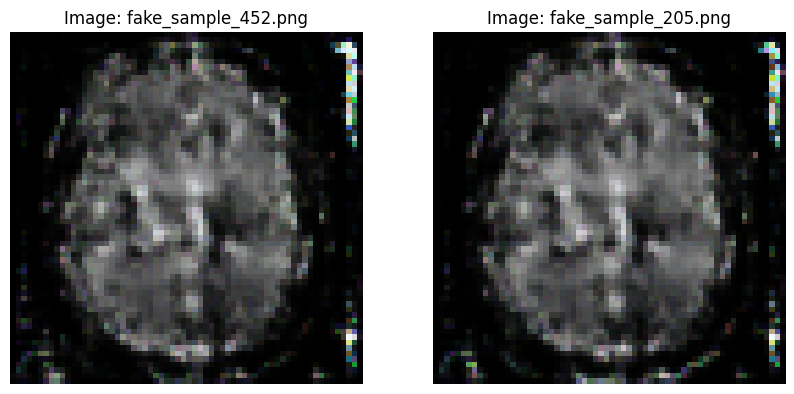

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define the output directory
output_directory = '/extracted_files/yes/'

# Check if the directory exists
if os.path.exists(output_directory):
    # List all files in the directory
    files = os.listdir(output_directory)
    print(f"Total number of files in the directory: {len(files)}")
    print(f"First 10 files in the directory: {files[:10]}")  # Print the first 10 filenames for inspection

    # Select two random files from the list
    image_files = random.sample(files, 2)  # Randomly pick two files

    # Set up the plot to display the two images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, image_file in enumerate(image_files):
        # Load the image
        img_path = os.path.join(output_directory, image_file)
        img = mpimg.imread(img_path)

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Image: {image_file}")  # Set the title to the image filename

    plt.show()  # Show the plot
else:
    print(f"The directory {output_directory} does not exist.")


In [ ]:
dataroot = "extarcted_files/no"

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2000
lr = 0.0002
beta1 = 0.5
ngpu = 1
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/extracted_files/DCGAN_results_epoch_300/no/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/2000][1/4]	Loss_D: 0.0850	Loss_G: 20.6446	D(x): 0.9422	D(G(z)): 0.0029 / 0.0002
[24/2000][3/4]	Loss_D: 0.0286	Loss_G: 6.8818	D(x): 0.9956	D(G(z)): 0.0235 / 0.0024
[37/2000][1/4]	Loss_D: 0.0116	Loss_G: 7.7933	D(x): 0.9978	D(G(z)): 0.0092 / 0.0015
[49/2000][3/4]	Loss_D: 0.0230	Loss_G: 6.1268	D(x): 0.9843	D(G(z)): 0.0067 / 0.0032
[62/2000][1/4]	Loss_D: 0.0198	Loss_G: 5.9770	D(x): 0.9950	D(G(z)): 0.0146 / 0.0032
[74/2000][3/4]	Loss_D: 0.0194	Loss_G: 6.3281	D(x): 0.9968	D(G(z)): 0.0159 / 0.0027
[87/2000][1/4]	Loss_D: 0.0120	Loss_G: 6.0217	D(x): 0.9975	D(G(z)): 0.0094 / 0.0030
[99/2000][3/4]	Loss_D: 0.0120	Loss_G: 6.2763	D(x): 0.9931	D(G(z)): 0.0049 / 0.0022
[112/2000][1/4]	Loss_D: 0.0598	Loss_G: 7.3528	D(x): 0.9639	D(G(z)): 0.0013 / 0.0021
[124/2000][3/4]	Loss_D: 0.0151	Loss_G: 6.4912	D(x): 0.9984	D(G(z)): 0.0129 / 0.0030
[137/2000][1/4]	Loss_D: 0.0081	Loss_G: 6.5588	D(x): 0.9935	D(G(z)): 0.0013 / 0.0017
[149/2000][3/4]	Loss_D: 0.0183	Loss_G: 6.3530	D(x): 0.998

In [ ]:
import os

directory = '/extracted_files/DCGAN_results_epoch_300/no/'

if os.path.exists(directory):
    print(f"The directory {directory} exists.")

    # Count the number of images (files) in the directory
    image_count = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        image_count += len(filenames)

    print(f"The total number of images in the directory is {image_count}.")
else:
    print(f"The directory {directory} does not exist.")


The directory /extracted_files/DCGAN_results_epoch_300/no/ exists.
The total number of images in the directory is 64.


In [ ]:
import os
import torch
import torchvision.utils as vutils

# Define the output directory
output_directory = '/extracted_files/no/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Number of images to generate
num_images_to_generate = 1500

# Generate the images and save them
for i in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Generate noise for a single image
    fake_image = netG(noise)  # Generate the image using the trained generator

    # Save the image
    vutils.save_image(fake_image.detach(), f'{output_directory}/fake_sample_{i + 1}.png', normalize=True)

    if (i + 1) % 50 == 0:
        print(f'Generated {i + 1}/{num_images_to_generate} images.')

print(f"Generated {num_images_to_generate} images and saved them in {output_directory}.")


Generated 50/1500 images.
Generated 100/1500 images.
Generated 150/1500 images.
Generated 200/1500 images.
Generated 250/1500 images.
Generated 300/1500 images.
Generated 350/1500 images.
Generated 400/1500 images.
Generated 450/1500 images.
Generated 500/1500 images.
Generated 550/1500 images.
Generated 600/1500 images.
Generated 650/1500 images.
Generated 700/1500 images.
Generated 750/1500 images.
Generated 800/1500 images.
Generated 850/1500 images.
Generated 900/1500 images.
Generated 950/1500 images.
Generated 1000/1500 images.
Generated 1050/1500 images.
Generated 1100/1500 images.
Generated 1150/1500 images.
Generated 1200/1500 images.
Generated 1250/1500 images.
Generated 1300/1500 images.
Generated 1350/1500 images.
Generated 1400/1500 images.
Generated 1450/1500 images.
Generated 1500/1500 images.
Generated 1500 images and saved them in /extracted_files/no/.
